In [1]:
#install.packages("ggmap", "/Users/yesla/Anaconda3/R/library", repos = "http://cran.us.r-project.org" )
library(data.table)
library(tidyverse)
library(plotly)
library(lubridate)
library(xts)
library(ggmap)
library(randomForest)
library(LiblineaR)
options(warn=-1)

Warning message:
"package 'tidyverse' was built under R version 3.4.3"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
Warning message:
"package 'tibble' was built under R version 3.4.3"Warning message:
"package 'tidyr' was built under R version 3.4.2"Warning message:
"package 'readr' was built under R version 3.4.2"Warning message:
"package 'purrr' was built under R version 3.4.3"Warning message:
"package 'dplyr' was built under R version 3.4.3"Warning message:
"package 'forcats' was built under R version 3.4.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()


In [2]:
setwd("C:/Users/yesla/Desktop/Kaggle/SanFranCrime/San-Fran-Crime-Analysis")

In [3]:
#Read in the data
sf_crime_train <- read.csv("train.csv")
sf_crime_test <- read.csv("test.csv")

In [4]:
#Look up summary stats and data types for the dataset
str(sf_crime_train)
str(sf_crime_test)
summary(sf_crime_train)

'data.frame':	878049 obs. of  9 variables:
 $ Dates     : Factor w/ 389257 levels "2003-01-06 00:01:00",..: 389257 389257 389256 389255 389255 389255 389255 389255 389254 389254 ...
 $ Category  : Factor w/ 39 levels "ARSON","ASSAULT",..: 38 22 22 17 17 17 37 37 17 17 ...
 $ Descript  : Factor w/ 879 levels "ABANDONMENT OF CHILD",..: 867 811 811 405 405 407 740 740 405 405 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
 $ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 1 1 1 12 12 12 12 12 12 12 ...
 $ Address   : Factor w/ 23228 levels "0 Block of  HARRISON ST",..: 19791 19791 22698 4267 1844 1506 13323 18055 11385 17659 ...
 $ X         : num  -122 -122 -122 -122 -122 ...
 $ Y         : num  37.8 37.8 37.8 37.8 37.8 ...
'data.frame':	884262 obs. of  7 variables:
 $ Id        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Dates     : Factor w/ 392173 levels "2003-01-01 00:01

                 Dates                  Category     
 2011-01-01 00:01:00:   185   LARCENY/THEFT :174900  
 2006-01-01 00:01:00:   136   OTHER OFFENSES:126182  
 2012-01-01 00:01:00:    94   NON-CRIMINAL  : 92304  
 2006-01-01 12:00:00:    63   ASSAULT       : 76876  
 2007-06-01 00:01:00:    61   DRUG/NARCOTIC : 53971  
 2006-06-01 00:01:00:    58   VEHICLE THEFT : 53781  
 (Other)            :877452   (Other)       :300035  
                                  Descript          DayOfWeek     
 GRAND THEFT FROM LOCKED AUTO         : 60022   Friday   :133734  
 LOST PROPERTY                        : 31729   Monday   :121584  
 BATTERY                              : 27441   Saturday :126810  
 STOLEN AUTOMOBILE                    : 26897   Sunday   :116707  
 DRIVERS LICENSE, SUSPENDED OR REVOKED: 26839   Thursday :125038  
 WARRANT ARREST                       : 23754   Tuesday  :124965  
 (Other)                              :681367   Wednesday:129211  
      PdDistrict                

In [5]:
#Check how many unique values in each column 
apply(sf_crime_train, 2, function(x) length(unique(x)))

Dates   Category   Descript  DayOfWeek PdDistrict Resolution    Address 
    389257         39        879          7         10         17      23228 
         X          Y 
      1387       9284

In [6]:
#Check unique resolutions and see if they can be grouped up
summary(sf_crime_train$Resolution)

ARREST, BOOKED                          ARREST, CITED 
                                206403                                  77004 
CLEARED-CONTACT JUVENILE FOR MORE INFO       COMPLAINANT REFUSES TO PROSECUTE 
                                   217                                   3976 
DISTRICT ATTORNEY REFUSES TO PROSECUTE                  EXCEPTIONAL CLEARANCE 
                                  3934                                   1530 
                   JUVENILE ADMONISHED                        JUVENILE BOOKED 
                                  1455                                   5564 
                        JUVENILE CITED                      JUVENILE DIVERTED 
                                  3332                                    355 
                               LOCATED                                   NONE 
                                 17101                                 526790 
                        NOT PROSECUTED           PROSECUTED BY OUTSIDE AGENCY 
                                  3714                                   2504 
         PROSECUTED FOR LESSER OFFENSE                      PSYCHOPATHIC CASE 
                                    51                                  14534 
                             UNFOUNDED 
                                  9585

In [7]:
#Function to build the training data set 
buildTrainDataSet <- function(full_set)
{
  full_set$Dates <- as.POSIXlt(as.POSIXct(full_set$Dates, format = "%Y-%m-%d %H:%M:%S", tz = "UTC"))
  full_set$Month <- full_set$Dates$mon + 1
  full_set$Year <- full_set$Dates$year + 1900
  full_set$HourOfDay <- full_set$Dates$hour
  full_set$TimeOfDay <-as.character(cut(full_set$Dates$hour, breaks=c(-Inf,4,10,16,22, Inf), labels = c("Night1", "Morning", "Noon", "Evening", "Night2")))
  full_set$TimeOfDay[full_set$TimeOfDay == 'Night1'] <- 'Night'
  full_set$TimeOfDay[full_set$TimeOfDay == 'Night2'] <- 'Night'
  full_set$TimeOfDay <- as.factor(full_set$TimeOfDay)
  full_set$Month <- as.factor(full_set$Month)
  full_set$Year <- as.factor(full_set$Year)
  full_set$HourOfDay <- as.factor(full_set$HourOfDay)
  
  return(full_set[,-1])
}

training_set <- buildTrainDataSet(sf_crime_train)
str(training_set)

'data.frame':	878049 obs. of  12 variables:
 $ Category  : Factor w/ 39 levels "ARSON","ASSAULT",..: 38 22 22 17 17 17 37 37 17 17 ...
 $ Descript  : Factor w/ 879 levels "ABANDONMENT OF CHILD",..: 867 811 811 405 405 407 740 740 405 405 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
 $ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 1 1 1 12 12 12 12 12 12 12 ...
 $ Address   : Factor w/ 23228 levels "0 Block of  HARRISON ST",..: 19791 19791 22698 4267 1844 1506 13323 18055 11385 17659 ...
 $ X         : num  -122 -122 -122 -122 -122 ...
 $ Y         : num  37.8 37.8 37.8 37.8 37.8 ...
 $ Month     : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Year      : Factor w/ 13 levels "2003","2004",..: 13 13 13 13 13 13 13 13 13 13 ...
 $ HourOfDay : Factor w/ 24 levels "0","1","2","3",..: 24 24 24 24 24 24 24 24 24 24 ...
 $ TimeOfDay : Factor w/ 4

In [25]:
#Function to build the the combination of the training and testing set 
buildFullDataSet <- function(train, test)
{
  full_set <- rbind((filt <- train %>% select(-Category, -Descript, -Resolution)), test[,-1])
  
  full_set$Dates <- as.POSIXlt(as.POSIXct(full_set$Dates, format = "%Y-%m-%d %H:%M:%S", tz = "UTC"))
  full_set$Month <- full_set$Dates$mon + 1
  full_set$Year <- full_set$Dates$year + 1900
  full_set$HourOfDay <- full_set$Dates$hour
  full_set$TimeOfDay <-as.character(cut(full_set$Dates$hour, breaks=c(-Inf,4,10,16,22, Inf), labels = c("Night1", "Morning", "Noon", "Evening", "Night2")))
  full_set$TimeOfDay[full_set$TimeOfDay == 'Night1'] <- 'Night'
  full_set$TimeOfDay[full_set$TimeOfDay == 'Night2'] <- 'Night'
  full_set$TimeOfDay <- as.factor(full_set$TimeOfDay)
  full_set$Month <- as.factor(full_set$Month)
  full_set$Year <- as.factor(full_set$Year)
  full_set$HourOfDay <- as.factor(full_set$HourOfDay)
  
  full_set <- full_set %>% select(c(-Address, -X, -Y, -Dates))
    
  return(full_set)
}

full_set <- buildFullDataSet(sf_crime_train, sf_crime_test)
str(full_set)

'data.frame':	1762311 obs. of  6 variables:
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
 $ Month     : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Year      : Factor w/ 13 levels "2003","2004",..: 13 13 13 13 13 13 13 13 13 13 ...
 $ HourOfDay : Factor w/ 24 levels "0","1","2","3",..: 24 24 24 24 24 24 24 24 24 24 ...
 $ TimeOfDay : Factor w/ 4 levels "Evening","Morning",..: 3 3 3 3 3 3 3 3 3 3 ...


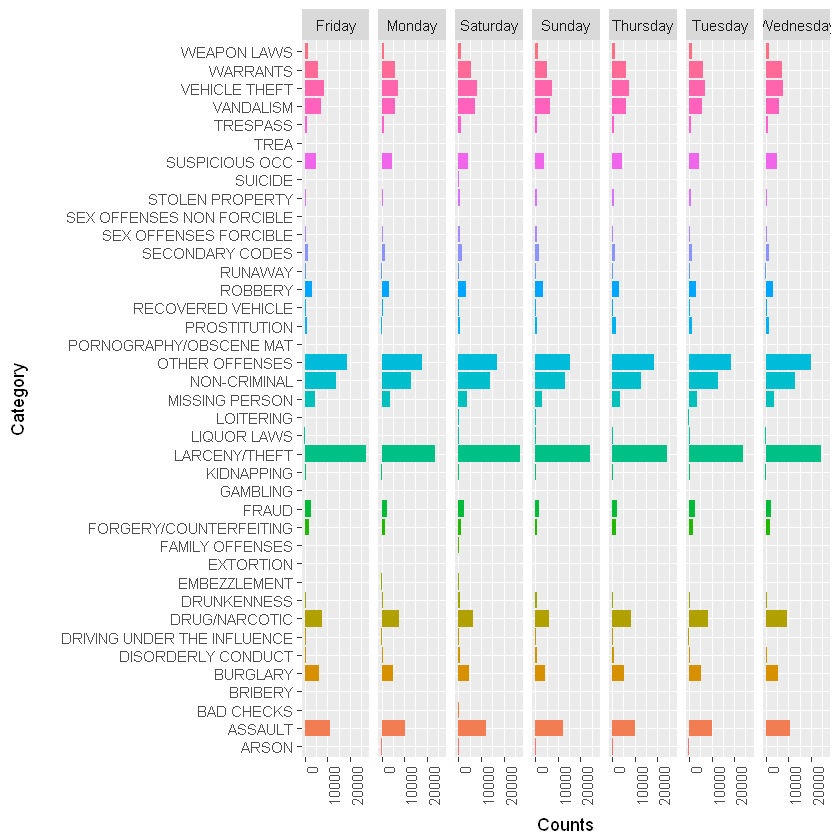

In [9]:
#Histogram of count of categories by day of week
table_cat <- table(training_set$Category, training_set$DayOfWeek)
table_cat <- as.data.frame(unlist(table_cat))
names(table_cat) <- c("Category", "DayOfWeek", "Counts")

total_hist_plot <- ggplot(data = table_cat, aes(x = Category, y = Counts, fill = Category)) +
                    geom_bar(stat = "Identity") + 
                    theme(legend.position = "none") +
                    coord_flip() + 
                    facet_grid(.~DayOfWeek) +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1))
total_hist_plot

In [9]:
#Top graph doesnt tell much so using top ten counts for category lets see variation in crime by day of weeks
top_10  <-  training_set %>%
                group_by(Category) %>%
                summarise(count = n()) %>%
                transform(Category = reorder(Category, -count)) %>%
                arrange(Category, desc(count))

labels <- top_10[1:10,1]

In [10]:
data  <-  training_set %>%
        subset(Category %in% labels) %>%
        group_by(DayOfWeek,Category,HourOfDay) %>%
        summarise(count = n()) 
head(data)

DayOfWeek,Category,HourOfDay,count
Friday,ASSAULT,0,596
Friday,ASSAULT,1,431
Friday,ASSAULT,2,381
Friday,ASSAULT,3,196
Friday,ASSAULT,4,131
Friday,ASSAULT,5,109


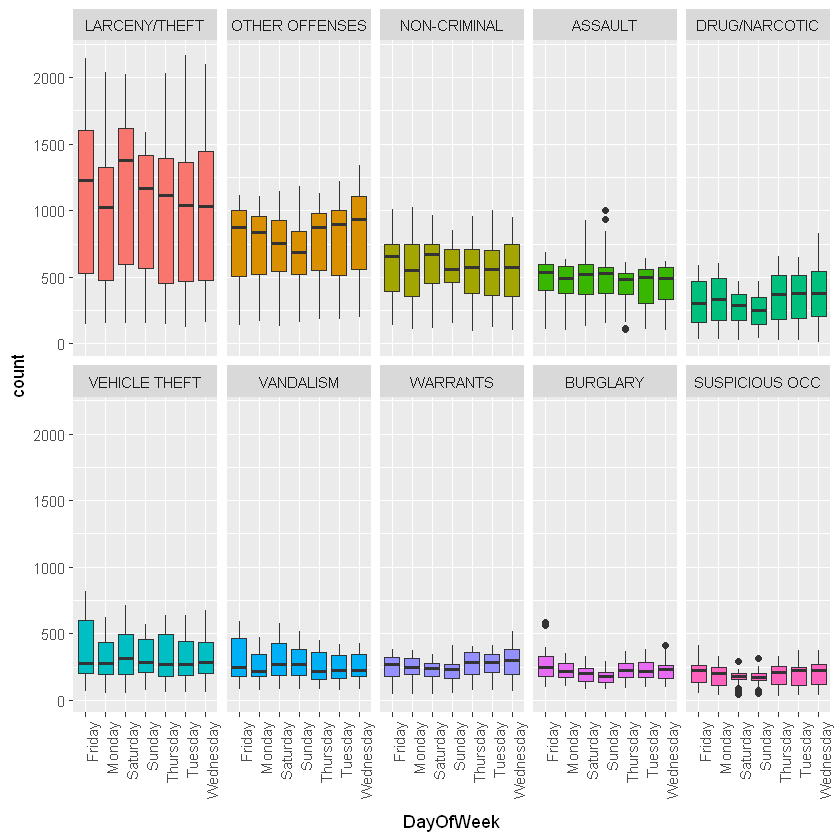

In [12]:
#Variation in crime for top ten most frequent crimes by day of week
data  <-  training_set %>%
        subset(Category %in% labels) %>%
        group_by(DayOfWeek,Category,HourOfDay) %>%
        summarise(count = n()) 

data$Category <- factor(data$Category, levels = labels)

ggplot(data = data,aes(x=DayOfWeek, y=count,fill = Category)) + 
        geom_boxplot() + 
        facet_wrap(~Category,ncol = 5)+
        theme(legend.position="None",
              axis.text.x = element_text(angle = 90, hjust = 1))

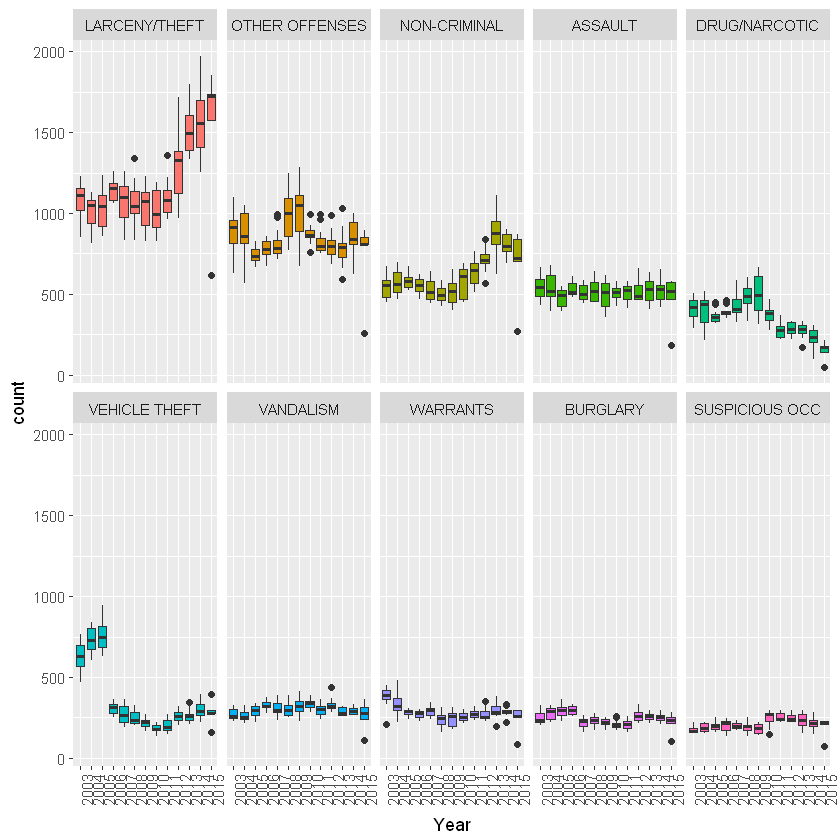

In [13]:
#Variation in crime for top ten most frequent crimes by Year
data  <-  training_set %>%
        subset(Category %in% labels) %>%
        group_by(Year,Category,Month) %>%
        summarise(count = n()) 

data$Category <- factor(data$Category, levels = labels)

ggplot(data = data,aes(x=Year, y=count,fill = Category)) + 
        geom_boxplot() + 
        facet_wrap(~Category,ncol = 5)+
        theme(legend.position="None",
              axis.text.x = element_text(angle = 90, hjust = 1))

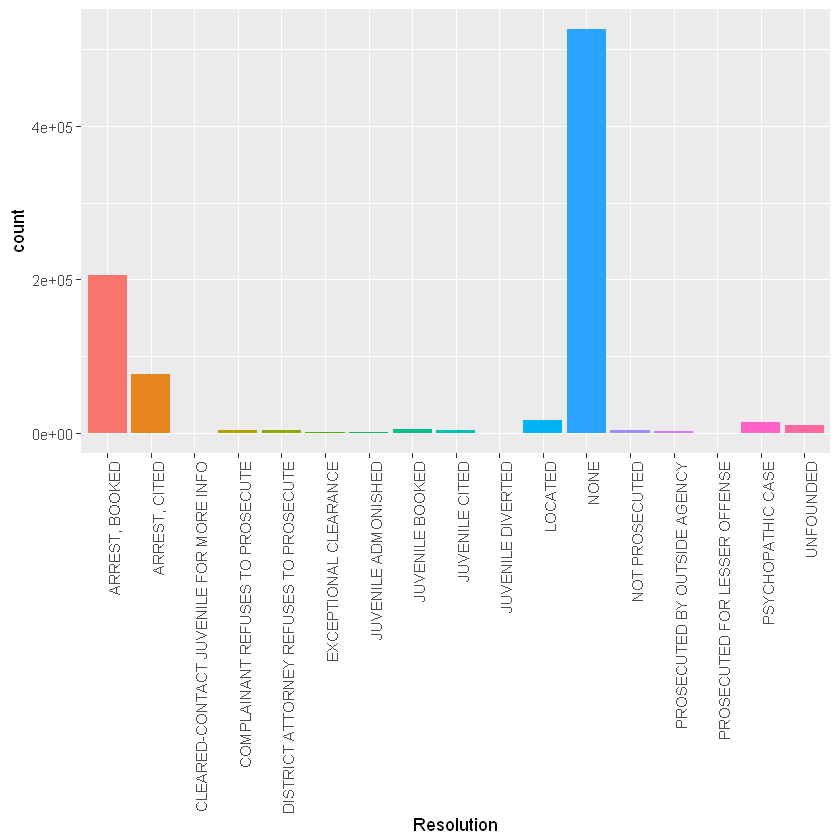

In [23]:
# Check distribution of classes 
data <- training_set %>%
            group_by(Resolution) %>%
            summarize(count = n())

ggplot(data = data, aes(x = Resolution, y = count, fill = Resolution)) +
        geom_bar(stat = "identity") +
        theme(legend.position="None",
              axis.text.x = element_text(angle = 90, hjust = 1))


In [15]:
str(training_set)

'data.frame':	878049 obs. of  12 variables:
 $ Category  : Factor w/ 39 levels "ARSON","ASSAULT",..: 38 22 22 17 17 17 37 37 17 17 ...
 $ Descript  : Factor w/ 879 levels "ABANDONMENT OF CHILD",..: 867 811 811 405 405 407 740 740 405 405 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
 $ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 1 1 1 12 12 12 12 12 12 12 ...
 $ Address   : Factor w/ 23228 levels "0 Block of  HARRISON ST",..: 19791 19791 22698 4267 1844 1506 13323 18055 11385 17659 ...
 $ X         : num  -122 -122 -122 -122 -122 ...
 $ Y         : num  37.8 37.8 37.8 37.8 37.8 ...
 $ Month     : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Year      : Factor w/ 13 levels "2003","2004",..: 13 13 13 13 13 13 13 13 13 13 ...
 $ HourOfDay : Factor w/ 24 levels "0","1","2","3",..: 24 24 24 24 24 24 24 24 24 24 ...
 $ TimeOfDay : Factor w/ 4

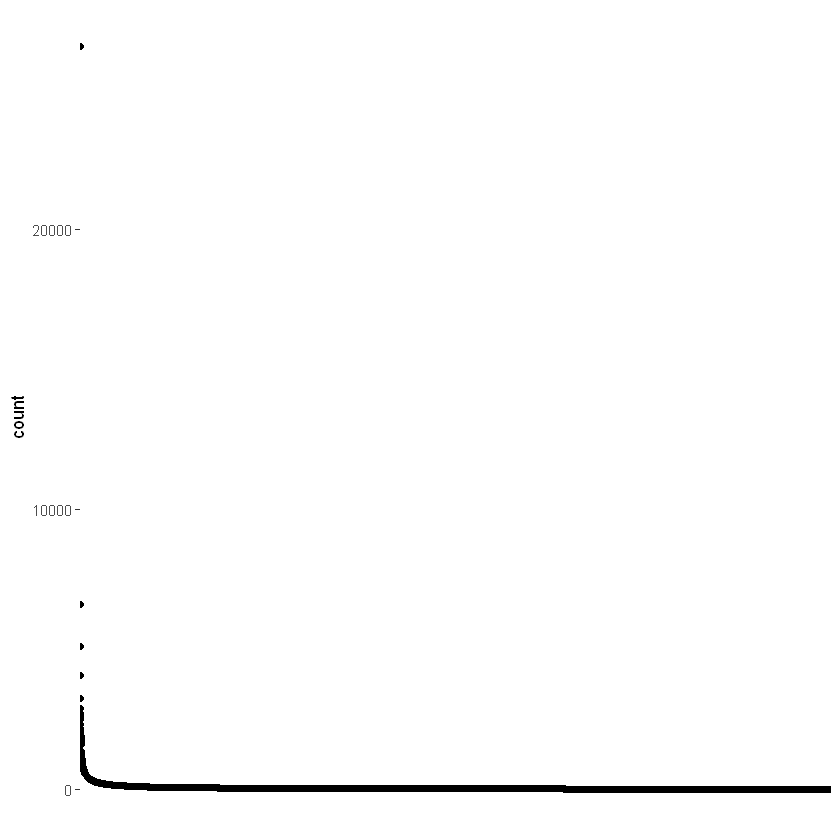

In [20]:
#Take  a look and see if we can do anything with address
data  <-  training_set %>%
                group_by(Address) %>%
                summarise(count = n()) %>%
                transform(Address = reorder(Address, -count)) %>%
                arrange(Address, desc(count))

ggplot(data = data, aes(x = Address, y = count)) +
        geom_point() + 
        theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

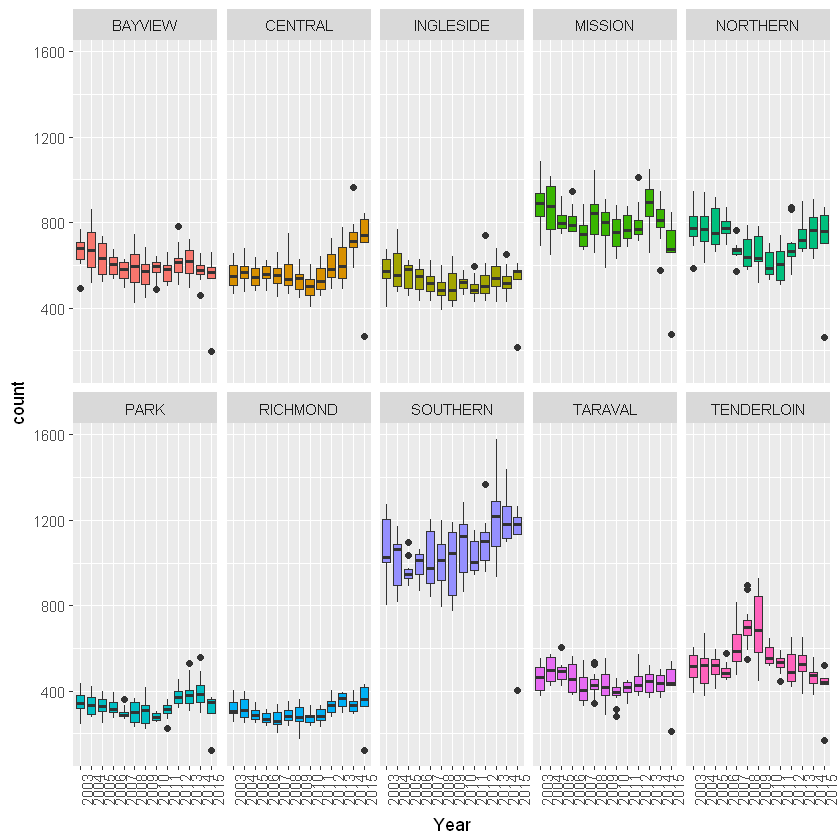

In [14]:
#Check which district crime is most prevalent

data  <-  training_set %>%
        group_by(Year, PdDistrict, Month) %>%
        summarise(count = n()) 



ggplot(data = data,aes(x = Year, y = count, fill = PdDistrict)) + 
        geom_boxplot() + 
        facet_wrap(~PdDistrict, ncol = 5)+
        theme(legend.position="None",
              axis.text.x = element_text(angle = 90, hjust = 1))

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


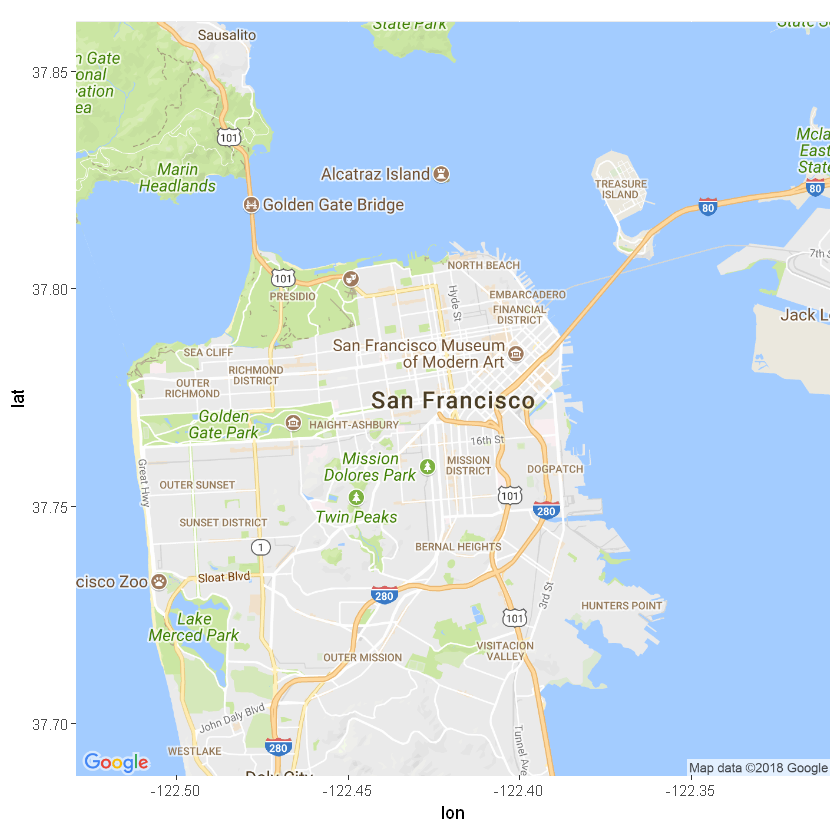

In [15]:
#Heat Map
map <- get_map("San Francisco", zoom =12, maptype = "roadmap")
ggmap(map) +
stat_density2d(data = training_set, aes(x = X, y = Y, fill = ..level.., alpha = ..level..),
               geom = "polygon", size = 0.01, bins = 16) +
scale_fill_gradient(low = "red", high = "green") +
scale_alpha(range = c(0, 0.3), guide = FALSE)

In [19]:
#Which year had the most crimes
data <- training_set %>%
            group_by(Year) %>%
            summarize(count = n()) %>%
            transform(Year = reorder(Year, -count)) %>%
            arrange(Year, desc(count))

data

Year,count
2013,75606
2014,74766
2003,73902
2004,73422
2012,71731
2005,70779
2008,70174
2006,69909
2009,69000
2007,68015


In [36]:
#Now Split back the training and testing set
chooseYear <- function(data_set, year){
    
    year_data <- data_set %>%
                filter(Year == year) %>%
                select(-Year)
    
    return(year_data)
}

train_set <- full_set[1:878049,]
test_set <- full_set[878050:1762311,]

resolution_2013 <- chooseYear(training_set, 2013) 

train_2013 <- chooseYear(train_set, 2013)
test_2013 <- chooseYear(test_set, 2013)

train_2013$Resolution <- resolution_2013$Resolution

In [38]:
str(train_2013)

'data.frame':	75606 obs. of  6 variables:
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 8 1 7 9 9 9 4 ...
 $ Month     : Factor w/ 12 levels "1","2","3","4",..: 12 12 12 12 12 12 12 12 12 12 ...
 $ HourOfDay : Factor w/ 24 levels "0","1","2","3",..: 24 24 24 24 24 24 24 24 24 24 ...
 $ TimeOfDay : Factor w/ 4 levels "Evening","Morning",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 12 12 12 16 12 12 12 1 1 1 ...


In [17]:

# set.seed(123)
# mark <- sample(2, nrow(train), replace = TRUE, prob = c(.7, .3))
# train <- train_set[mark==1, ]
# val <- train_set[mark==2, ]
# train_label <- train$Resolution
# val_label <- val$Resolution

In [39]:
#Time to perform RandomForest takes around ten minutes
fit <- randomForest(Resolution ~ DayOfWeek + PdDistrict + Month + HourOfDay + TimeOfDay, 
                      data = train_2013,
                      importance = TRUE)

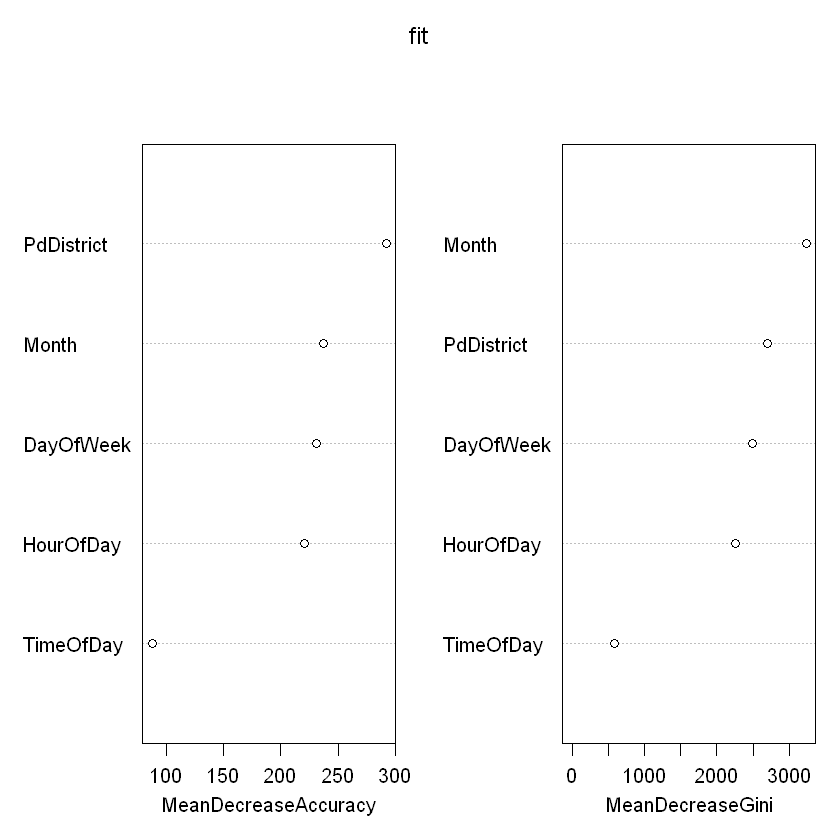

In [40]:
varImpPlot(fit)

In [41]:
print(fit)


Call:
 randomForest(formula = Resolution ~ DayOfWeek + PdDistrict +      Month + HourOfDay + TimeOfDay, data = train_2013, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 37.28%
Confusion matrix:
                                       ARREST, BOOKED ARREST, CITED
ARREST, BOOKED                                   4624            34
ARREST, CITED                                     531           185
CLEARED-CONTACT JUVENILE FOR MORE INFO              0             0
COMPLAINANT REFUSES TO PROSECUTE                  159             2
DISTRICT ATTORNEY REFUSES TO PROSECUTE             15             3
EXCEPTIONAL CLEARANCE                              10             3
JUVENILE ADMONISHED                                 2             0
JUVENILE BOOKED                                    56             2
JUVENILE CITED                                

In [45]:
library(caret)
confusionMatrix(fit$predicted, train_2013$Resolution)

package 'mgcv' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yesla\AppData\Local\Temp\Rtmpqo6yhD\downloaded_packages



Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



Confusion Matrix and Statistics

                                        Reference
Prediction                               ARREST, BOOKED ARREST, CITED
  ARREST, BOOKED                                   4624           531
  ARREST, CITED                                      34           185
  CLEARED-CONTACT JUVENILE FOR MORE INFO              0             0
  COMPLAINANT REFUSES TO PROSECUTE                    7             3
  DISTRICT ATTORNEY REFUSES TO PROSECUTE              0             1
  EXCEPTIONAL CLEARANCE                               0             0
  JUVENILE ADMONISHED                                 0             0
  JUVENILE BOOKED                                     1             1
  JUVENILE CITED                                      1             0
  JUVENILE DIVERTED                                   0             0
  LOCATED                                             6             3
  NONE                                            11918          5051
  NOT P

In [ ]:
model <- LiblineaR(train, target, type = 7, verbose = FALSE)